This is a DEMO for loading a pre-trained eqpolarity model and applying transfer learning on Texas data

Make sure eqpolarity is installed following the instructions on the main website
https://github.com/chenyk1990/eqpolarity

In [1]:
## Import data
#polall is polarity label from Texas (Size: 22980x1)
#datall is 600-sample waveform data (Z-component) from Texas (Size: 22980 x 600 x 1); the waveform is centered by P-arrival (manual from Texas analysts) sample

import numpy as np

# datall_Texas.npy can also be downloaded from https://mega.nz/file/chxx1Z5Y#zXNRKT5aeNy7AGREKEUIq71TREK8hcUyXA1ZOkQ9DlM
# datall = np.load('../data/TexasData/datall_Texas.npy') 
polall = np.load('../data/TexasData/polall_Texas.npy')

data=[]
for ii in range(6):
    data.append(np.load('../data/TexasData/datall_Texas%d.npy'%(ii+1)))
datall=np.concatenate(data,axis=0)


In [2]:
## Load EQpolarity model
from eqpolarity.utils import construct_model
input_shape = (600,1)
model=construct_model(input_shape)
model.summary()

2024-08-09 18:50:41.253468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 600, 1)]             0         []                            
                                                                                                  
 cct_tokenizer1 (CCTTokeniz  (None, 150, 200)             160800    ['input[0][0]']               
 er1)                                                                                             
                                                                                                  
 layer_normalization (Layer  (None, 150, 200)             400       ['cct_tokenizer1[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [3]:
## Load pre-trained model for prediction
model.load_weights('../models/best_weigths_Binary_SCSN_Best.h5')
out = model.predict(datall,batch_size=1024, verbose=1)

23/23 [==============================] - 402s 17s/step


In [4]:
## Applying threshold
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall

## Calculating accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.9459094865100087,
 0.9459094865100087,
 0.9459094865100087,
 0.9459094865100087)

In [5]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

(0.9459094865100087,
 array([0.97869277, 0.89579665]),
 array([0.93488276, 0.96491644]),
 array([0.95628627, 0.92907275]))

In [6]:
#Generate the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labtest, outtest)
print(cf_matrix)

[[13596   947]
 [  296  8141]]


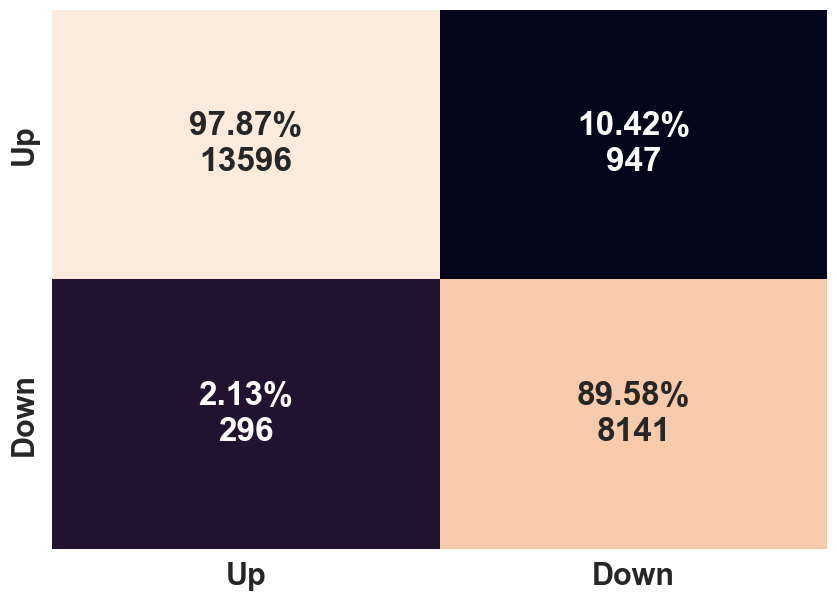

In [19]:
## plotting confusion matrix
from eqpolarity import plot_confusionmatrix
plot_confusionmatrix(cf=cf_matrix,categories=['Up','Down'],figname='Conf_Matrix_before_transferlearning.png',ifshow=True)

In [7]:
# weightname='best_weigths_Binary_Texas_Transfer10.weights.h5'
import datetime
today=datetime.date.today()
weightname='best_weigths_Binary_Texas_Transfer10_%s.weights.h5'%str(today) #make the weight different by date


## training setup
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath=weightname,
                             monitor='val_acc',
                             mode = 'max',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                                   cooldown=0,
                                   patience=50,
                                   min_lr=0.5e-6,
                                   monitor='val_acc',
                                   mode = 'max',
                                  verbose= 1)

In [8]:
ind = np.random.permutation(len(datall))
a = int(10*len(ind)/100)
ind = ind[0:a]
x = datall[ind]
y = polall[ind]

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=['binary_crossentropy'], metrics=['acc'])
model.load_weights('../models/best_weigths_Binary_SCSN_Best.h5')

model.fit(x, y, batch_size=128, epochs=50, verbose =1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,lr_reducer])

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.0925 - acc: 0.9705  
Epoch 1: val_acc improved from -inf to 0.98696, saving model to best_weigths_Binary_Texas_Transfer10_2024-08-09.weights.h5
17/17 [==============================] - 1276s 79s/step - loss: 0.0925 - acc: 0.9705 - val_loss: 0.0273 - val_acc: 0.9870 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.0532 - acc: 0.9860
Epoch 2: val_acc improved from 0.98696 to 0.99130, saving model to best_weigths_Binary_Texas_Transfer10_2024-08-09.weights.h5
17/17 [==============================] - 106s 6s/step - loss: 0.0532 - acc: 0.9860 - val_loss: 0.0228 - val_acc: 0.9913 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.0432 - acc: 0.9879
Epoch 3: val_acc did not improve from 0.99130
17/17 [==============================] - 105s 6s/step - loss: 0.0432 - acc: 0.9879 - val_loss: 0.0293 - val_acc: 0.9826 - lr: 0.0010
Epoch 4/50
17/17 [=================

In [9]:
model.load_weights(weightname)
out = model.predict(datall,batch_size=1024, verbose=1)

23/23 [==============================] - 312s 14s/step


In [10]:
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall


In [11]:
## plotting different types of accuracy
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.9823324630113142,
 0.9823324630113142,
 0.9823324630113142,
 0.9823324630113142)

In [12]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

(0.9823324630113142,
 array([0.984177  , 0.97911944]),
 array([0.98796672, 0.9726206 ]),
 array([0.98606822, 0.9758592 ]))

In [13]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='macro'),recall_score(labtest,outtest, average='macro'),f1_score(labtest,outtest, average='macro')

(0.9823324630113142,
 0.9816482176229657,
 0.9802936595615699,
 0.9809637080852494)

In [14]:
cf_matrix = confusion_matrix(labtest, outtest)
print(cf_matrix)



[[14368   175]
 [  231  8206]]


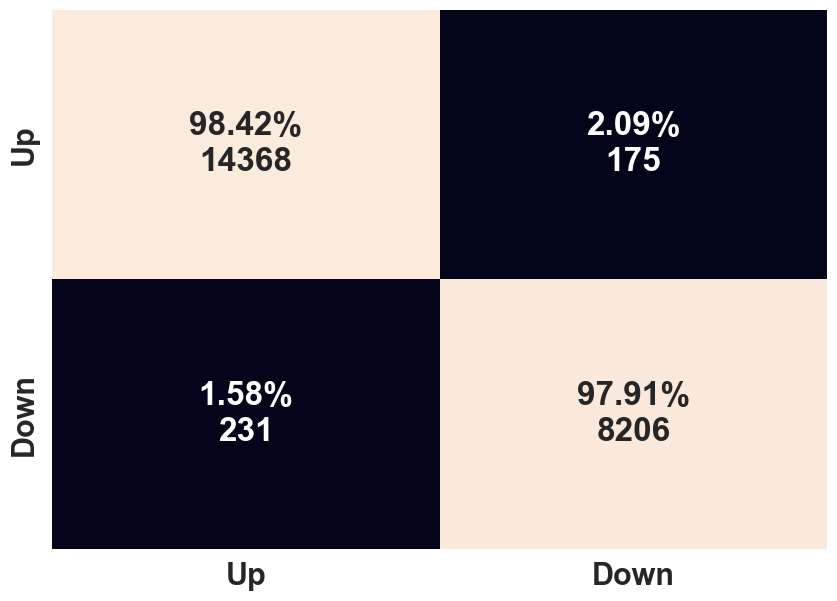

In [17]:
## plot confusion matrix
from eqpolarity import plot_confusionmatrix
plot_confusionmatrix(cf=cf_matrix,categories=['Up','Down'],figname='Conf_Matrix_after_transferlearning.png',ifshow=True)